In this project we build a model to predict whether or not tumours are benign or malignant.
We use the Wisconsin Breast Cancer Dataset located here:
http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

We first do some prelimary exploration of the data. This is followed by a number of
feature engineering steps that involve transformations of the data.
Once we have prepared the data we split the data into a training set and a test set.

We then experiment with a number of different models and hyperparameter combinations.
We train the combinations using hold out validation with the GridSearchCV class using
only the training set. For each best combination we then run predictions on the test set
to get a score. We use recall as the primary error metric under the assumption that we don't
want to incorrectly classify a malignant tumour as benign. We encoded the diagnostic
label column to have values 1 - malignant, 0 - benign.

We use precision and roc_auc as secondary error metrics.

Once we have identified a number of best estimators among the classifier type/
hyperparameter combinations we then use them to create an ensemble voting classifier to
produce a final result using the test data set.

We organize the code into a series of classes and functions that can be used to perform the
various data transformation and model testing tasks required.

In [86]:
import pandas as pd

data = pd.read_csv('data.csv')
data.shape

(569, 33)

There are 569 rows with 33 columns in the dataset.

In [87]:
pd.set_option('display.max_columns', 999)
data.describe(include='all')

id diagnosis  radius_mean  texture_mean  perimeter_mean  \
count   5.690000e+02       569   569.000000    569.000000      569.000000   
unique           NaN         2          NaN           NaN             NaN   
top              NaN         B          NaN           NaN             NaN   
freq             NaN       357          NaN           NaN             NaN   
mean    3.037183e+07       NaN    14.127292     19.289649       91.969033   
std     1.250206e+08       NaN     3.524049      4.301036       24.298981   
min     8.670000e+03       NaN     6.981000      9.710000       43.790000   
25%     8.692180e+05       NaN    11.700000     16.170000       75.170000   
50%     9.060240e+05       NaN    13.370000     18.840000       86.240000   
75%     8.813129e+06       NaN    15.780000     21.800000      104.100000   
max     9.113205e+08       NaN    28.110000     39.280000      188.500000   

          area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count    569.000000       569.000000        569.000000      569.000000   
unique          NaN              NaN               NaN             NaN   
top             NaN              NaN               NaN             NaN   
freq            NaN              NaN               NaN             NaN   
mean     654.889104         0.096360          0.104341        0.088799   
std      351.914129         0.014064          0.052813        0.079720   
min      143.500000         0.052630          0.019380        0.000000   
25%      420.300000         0.086370          0.064920        0.029560   
50%      551.100000         0.095870          0.092630        0.061540   
75%      782.700000         0.105300          0.130400        0.130700   
max     2501.000000         0.163400          0.345400        0.426800   

        concave points_mean  symmetry_mean  fractal_dimension_mean  \
count            569.000000     569.000000              569.000000   
unique                  NaN            NaN                     NaN   
top                     NaN            NaN                     NaN   
freq                    NaN            NaN                     NaN   
mean               0.048919       0.181162                0.062798   
std                0.038803       0.027414                0.007060   
min                0.000000       0.106000                0.049960   
25%                0.020310       0.161900                0.057700   
50%                0.033500       0.179200                0.061540   
75%                0.074000       0.195700                0.066120   
max                0.201200       0.304000                0.097440   

         radius_se  texture_se  perimeter_se     area_se  smoothness_se  \
count   569.000000  569.000000    569.000000  569.000000     569.000000   
unique         NaN         NaN           NaN         NaN            NaN   
top            NaN         NaN           NaN         NaN            NaN   
freq           NaN         NaN           NaN         NaN            NaN   
mean      0.405172    1.216853      2.866059   40.337079       0.007041   
std       0.277313    0.551648      2.021855   45.491006       0.003003   
min       0.111500    0.360200      0.757000    6.802000       0.001713   
25%       0.232400    0.833900      1.606000   17.850000       0.005169   
50%       0.324200    1.108000      2.287000   24.530000       0.006380   
75%       0.478900    1.474000      3.357000   45.190000       0.008146   
max       2.873000    4.885000     21.980000  542.200000       0.031130   

        compactness_se  concavity_se  concave points_se  symmetry_se  \
count       569.000000    569.000000         569.000000   569.000000   
unique             NaN           NaN                NaN          NaN   
top                NaN           NaN                NaN          NaN   
freq               NaN           NaN                NaN          NaN   
mean          0.025478      0.031894           0.011796     0.020542   
std           0.017908      0.

In [88]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

We will drop the id and Unnamed 32: columns. The diagnosis column has values B - benign,
M - malignant. We will encode this as the label column. All of the reaming other columns are numeric
with no missing values. These will be used as the feature columns.

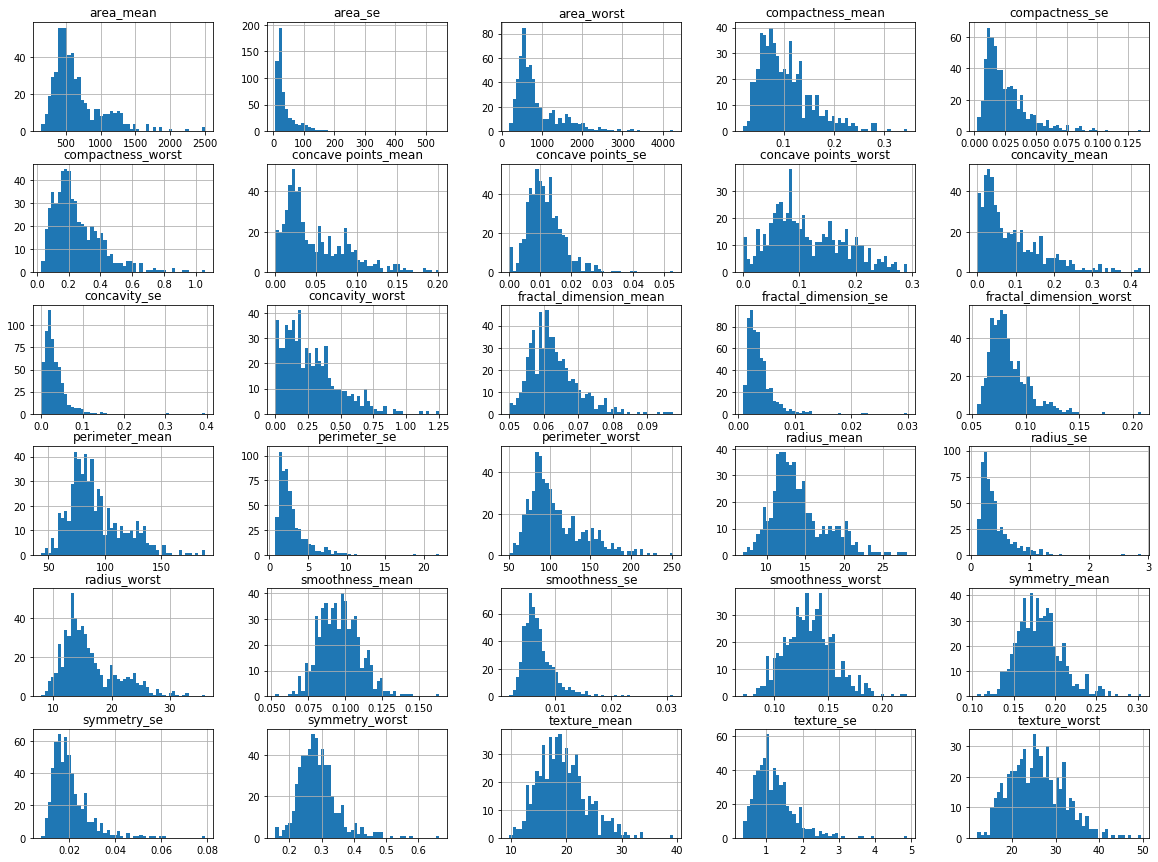

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

feature_data = data.drop(['diagnosis','Unnamed: 32','id'],axis=1)

feature_data.hist(bins=50,figsize=(20,15))
plt.show()


The feature columns have a wide variation in ranges of values. The distributions are mostly symetric roughly bell shaped.
Some distributions are skewed. In many cases there are also outliers. We will standardize the values to z scores
to eliminate the variation in distributions. In addition we will eliminate rows that contain outliers.

We now define the set of classes and functions that will be used later on in the notebook.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from enum import IntEnum


class DataWorkFlow:
    """
    Work flow class for preparing data from a file to be used to test a model.
    Parameters
    ----------
    file_name: string
        Path of file containing data
    Attributes
    ----------
    train_set_X : Defined only after calling create_train_test_sets
        training set X
    train_set_y : Defined only after calling create_train_test_sets
        training set y
    test_set_X : Defined only after calling create_train_test_sets
        test set X
    test_set_y : Defined only after calling create_train_test_sets
        test set y
    """

    class State(IntEnum):
        """
        Enum specifying various states of the work flow. Used to force methods to
        be called in the right order.
        """
        INIT = 5
        LOADED = 10
        PRE_PREPARED = 20
        REMOVE_CORRELATED = 30
        ADDED_POLY_FEATURES = 35
        SCALED_COLUMNS = 40
        REMOVED_UNIMPORTANT = 40
        CREATE_TRAIN_TEST_SETS = 50
        
    def _validate_state(self,minimum_state):
        """
        Ensure that current state is this state or later in the work flow.
        Parameters
        ----------
        minimum_state : must be in this state or higher
        Returns
        -------
        C : array, shape (n_samples,)
            Returns predicted values.
        """
        if self._state < minimum_state:
            raise Exception(f'Workflow must have reached a minimum state of {minimum_state.name} '+
                           'in order to call this method')
        
    def __init__(self,file_name):
        """
        Parameters
        ----------
        file_name : Path of file containing data.
        """
        if (file_name == None):
            raise Exception("file name is required in constructor")
        self._file_name = file_name
        self._state = self.State.INIT
        self._removed_corr_columns = []
        self._removed_unimportant_columns = []
        self._removed_outlier_row_count = 0
        
    
    def load_file(self):
        """
        Loads file into dataframe
        """
        self._data = pd.read_csv(self._file_name)
        self._state = self.State.LOADED
    
    def pre_prepare_data(self):
        """
        Initial preparation of data. Creates a _feature_data dataframe for features
        and a _labels dataframe for encoded labels. 1 - means malignant, 0 -benign
        """
        self._validate_state(self.State.LOADED)
        self._feature_data = self._data.drop(['id','Unnamed: 32','diagnosis'],axis=1)
        labEncoder = LabelEncoder()
        self._labels = self._data[['diagnosis']].apply(labEncoder.fit_transform)
        self._state = self.State.PRE_PREPARED

    def prepare_data(self):
        """
        Prepares data calling the various other functions to do specific preparation
        tasks.
        """
        pre_prepare_data()
        remove_correlated_columns()
        #add_polynomial_features()
        scale_columns()
        remove_unimportant_features()
        
            
    def add_polynomial_features(self,degree=2):
        """
        Adds polynomial features to the data.
        """
        self._validate_state(self.State.PRE_PREPARED)
        poly_features = PolynomialFeatures(degree=degree,include_bias=False)
        poly_data = poly_features.fit_transform(self._feature_data)
        new_column_names = [f'POLY{i}' for i in range(poly_data.shape[1]-len(self._feature_data.columns))]
        self._feature_data = pd.DataFrame(poly_data,columns = list(self._feature_data.columns) + new_column_names)
        self._state = self.State.ADDED_POLY_FEATURES

    def remove_correlated_columns(self):
        """
        Removes columns that are correlated to other columns
        """
        self._validate_state(self.State.PRE_PREPARED)
        corr = self._feature_data.corr()

        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if corr.iloc[i,j] >= 0.9:
                    if columns[j]:
                        columns[j] = False

        selected_columns = corr.columns[columns]
        removed_columns = corr.columns[~columns]
        self._removed_corr_columns = list(removed_columns)

        self._feature_data=self._feature_data[selected_columns]
        self._state = self.State.REMOVE_CORRELATED
        
        
    def scale_columns(self):
        """
        Scales feature columns to z scores
        """
        self._validate_state(self.State.PRE_PREPARED)
        standardScaler = StandardScaler()
        scaled_data = standardScaler.fit_transform(self._feature_data)
        self._feature_data = pd.DataFrame(scaled_data,columns = self._feature_data.columns)
        self._state = self.State.SCALED_COLUMNS
        
    def remove_unimportant_features(self,regularization = 1):
        """
        Uses l1, lasso, regularization to identify and remove features that do not
        contribute strongly to the result. Using l1 regularization we eliminate all
        features whose computed weights using LogisticRegression equal 0.

        Parameters
        ----------
        regularization : inverse of l1 regularization strength. Smaller values
            will cause more features to be removed.
        """
        self._validate_state(self.State.PRE_PREPARED)
        logreg = LogisticRegression(C=regularization, solver='liblinear',penalty="l1", dual=False)
        logreg.fit(self._feature_data, self._labels.iloc[:,0])
        model_ = SelectFromModel(logreg, prefit=True)
        data_new_features = model_.transform(self._feature_data)
        picked_cols = model_.get_support(True)
        orig_columns = self._feature_data.columns
        self._feature_data = self._feature_data.iloc[:,picked_cols]
        self._removed_unimportant_columns = list(set(orig_columns)-set(self._feature_data.columns))
        self._state = self.State.REMOVED_UNIMPORTANT
        
    def create_train_test_sets(self, remove_train_std_threshold=None):
        """
        Randomly partitions features and labels into a training set
        and test set.
        
        Parameters
        ----------
        remove_train_std_threshold : Any rows that have any feature whose 
            value is this many standard deviations away from mean will be 
            removed. If we specify a value of None no rows will be removed.
            We assume that the feature values are z-scores so we do this by 
            simply checking if value greater than this value of less than
            the negative of this value in order to qualify for removal.
        """
        self._validate_state(self.State.PRE_PREPARED)
        feature_data = self._feature_data.join(self._labels)
        
        train_set, test_set = train_test_split(feature_data, test_size=.2,random_state=42)

        self.train_set_X = train_set.drop('diagnosis',axis=1)
        self.train_set_y = train_set[['diagnosis']]
        self.test_set_X = test_set.drop('diagnosis',axis=1)
        self.test_set_y = test_set[['diagnosis']]
        if remove_train_std_threshold != None:
            self.remove_train_outliers(remove_train_std_threshold)
    
    def remove_train_outliers(self, std_threshold=4):
        """
        Randomly partitions features and labels into a training set
        and test set.
        
        Parameters
        ----------
        std_threshold : Any rows that have any feature whose 
            value is this many standard deviations away from mean will be 
            removed. If we specify a value of None no rows will be removed.
            We assume that the feature values are z-scores so we do this by 
            simply checking if value greater than this value of less than
            the negative of this value in order to qualify for removal.
        """
        self._train_set_row_count = len(self.train_set_X.index)
        keep_filter = ((self.train_set_X.max(axis=1) < std_threshold)
            & (self.train_set_X.min(axis=1) > -std_threshold))
        self.train_set_X = self.train_set_X[keep_filter]
        self.train_set_y = self.train_set_y[keep_filter]
        self._removed_outlier_row_count = (~keep_filter).sum()
        
    def display_stats(self):
        """
        Display statistics about data preparation process.
        """
        print(f'Correlated Columns Removed:')
        for col in self._removed_corr_columns:
            print (f'  {col}')
        print(f'\nUnimportant Columns Removed:')
        for col in self._removed_unimportant_columns:
            print (f'  {col}')
        print(f'\nRemoved {self._removed_outlier_row_count} outlier rows out of ' +
              f'{self._train_set_row_count} train set rows')
        


In [139]:
from sklearn.model_selection import GridSearchCV
import pprint
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from mlxtend.classifier import EnsembleVoteClassifier

class ModelTester:
    """
    Class to facilitate running tests on various models and
    hyperparameter combinations.

    Parameters
    ----------
    train_set_X : data frame of training data features
    train_set_y : data frame of training data labels
    test_set_X : data frame of test  data features
    test_set_y : data frame of test data labels
    
    Attributes
    ----------
    last_test_roc_auc_score : 
    last_test_recall_score : 
    last_test_precision_score :
    num_features : Number of features found in train_set_X
    last_best_score :
    last_best_estimator :
    last_best_params :
    last_cv_results : List of  results for all calls to grid_search_next
    vote_test_roc_auc_score :
    vote_test_recall_score :
    vote_test_precision_score :
    test_results : List of test results for all calls to test_and_score
    grid_search_results : List of all results for call calls to grid_search_next
    
    See Also
    --------

    Notes
    -----
    Attributes beginning with last_test_ reflect values from most recent
    call to test_and_score. Attributes that begin with last_best_ or last_cv
    reflect values from most recent call to grid_search_next
    Attributes beginning with vote_test_ reflect values returned from most
    recent call to test_voting_and_score.
    
    Examples
    --------    
    """
    
    class GridSearchResult:
        """
        Value object that contains the results of a call to grid_search_next.
        They reflect values returned from GridSearchCV class.

        Parameters
        ----------
        best_score : 
        best_estimator :
        best_params : 
        cv_results : 
        """
        def __init__(self, best_score, best_estimator, best_params, cv_results):
            self.best_score = best_score
            self.best_estimator = best_estimator
            self.best_params = best_params
            self.cv_results = cv_results

    class TestResult:
        """
        Value object that contains the results of a call to grid_search_next.
        They reflect values returned from GridSearchCV class. The first 4
        params reflect values from estimator that was used to run the test.

        Parameters
        ----------
        best_score : 
        best_estimator :
        best_params : 
        cv_results : 
        test_recall_score : 
        test_precision_score :
        test_roc_auc_score :
        """
        def __init__(self, best_score, best_estimator, best_params, cv_results,
                    test_recall_score, test_precision_score, test_roc_auc_score):
            self.best_score = best_score
            self.best_estimator = best_estimator
            self.best_params = best_params
            self.cv_results = cv_results
            self.test_recall_score = test_recall_score
            self.test_precision_score = test_precision_score
            self.test_roc_auc_score = test_roc_auc_score
        
    def __init__(self, train_set_X, train_set_y, test_set_X, test_set_y):
        self._train_set_X = train_set_X
        self._train_set_y = train_set_y
        self._test_set_X = test_set_X
        self._test_set_y = test_set_y
        self.num_features = len(train_set_X.columns)
        self.grid_search_results = []
        self.test_results = []
        
    def grid_search_next(self,model,param_grid,cv=5):
        """
        Calls GridSearchCV using mode and param_grid. Fits training set
        to it and stores results in instance attributes that begin with last_best
        or last_cv.
        Also appends results to the list grid_search_results.
        
        Parameters
        ----------
        model : Model to test
        param_grid : hyperparameter grid to use
        cv : Number of folds to use.
        """

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall',return_train_score=True,iid=False)

        grid_search.fit(self._train_set_X, self._train_set_y.iloc[:,0])
        
        self.last_best_score = grid_search.best_score_
        self.last_best_estimator = grid_search.best_estimator_
        self.last_best_params = grid_search.best_params_
        self.last_cv_results = grid_search.cv_results_
        self.grid_search_results.append(self.GridSearchResult(grid_search.best_score_,
                                                             grid_search.best_estimator_,
                                                             grid_search.best_params_,
                                                             grid_search.cv_results_))
        
    def display_last_results(self):
        """
        Displays results of last call to grid_search_next
        """
        pp = pprint.PrettyPrinter()
        print("Best Estimator:")
        print(self.last_best_estimator)
        print("\nBest Params:")
        print(self.last_best_params)
        print("\nBest Results:")
        pp.pprint(self.last_cv_results)
        
    def test_and_score(self,test_set_X=None, test_set_y=None):
        """
        Uses the best estimator generated from most recent call to 
        grid_search_next to predict labels using test set features.
        Stores results in last_test_ attributes.
        Also appends results to test_results list.
        
        Parameters
        ----------
        test_set_X : Test features. If None then use value passed in constructor.
        test_set_y : Test labels. If None then use value passed in constructor.
        """
        if test_set_X is None:
            test_set_X = self._test_set_X
        if test_set_y is None:
            test_set_y = self._test_set_y
        test_pred = self.last_best_estimator.predict(test_set_X)
        self.last_test_roc_auc_score = roc_auc_score(test_set_y.iloc[:,0], test_pred)
        self.last_test_recall_score = recall_score(test_set_y.iloc[:,0], test_pred)
        self.last_test_precision_score = precision_score(test_set_y.iloc[:,0], test_pred)
        self.test_results.append(self.TestResult(self.last_best_score,
                                                 self.last_best_estimator,
                                                 self.last_best_params,
                                                 self.last_cv_results,
                                                 self.last_test_roc_auc_score,
                                                 self.last_test_recall_score,
                                                 self.last_test_precision_score))

    def test_voting_and_score(self):
        """
        Uses all of the best estimators from all prior calls to 
        grid_search_next to construct an EnsembleVoteClassifier which it then
        uses to predict labels using the test set passed into constructor.
        It does not refit the best estimators before doing the predicting.
        It uses the existing best estimator weights.
        Stores results in last_vote_test_ attributes.
        
        Typically you would call grid_search_next to generate a list of fitted
        estimators which are stored in test_results list. Then you call this
        method to use them all to do an ensemble prediction.
        """
        estimators = [result.best_estimator for result in self.test_results]
        voting = EnsembleVoteClassifier(estimators, voting='hard',refit=False)
        voting.fit(self._train_set_X,self._train_set_y.iloc[:,0])
        test_pred = voting.predict(self._test_set_X)
        #print(f'test_pred_shape {test_pred.shape}')
        self.vote_test_roc_auc_score = roc_auc_score(self._test_set_y.iloc[:,0], test_pred)
        self.vote_test_recall_score = recall_score(self._test_set_y.iloc[:,0], test_pred)
        self.vote_test_precision_score = precision_score(self._test_set_y.iloc[:,0], test_pred)
    
    def display_vote_results(self):
        """
        Display prediction results for prior call to test_voting_and_score
        """
        print(f'\nROC AUC Score: {self.vote_test_roc_auc_score}:')
        print(f'  Recall Score: {self.vote_test_recall_score}')
        print(f'  Precision Score: {self.vote_test_precision_score}')
    
    def display_grid_search_results(self):
        """
        Display results for all prior calls to grid_search_next
        """
        for i in range(len(self.grid_search_results)):
            result = self.grid_search_results[i]
            print(f'\nEstimator: {result.best_estimator}:')
            print(f'  Best Score: {result.best_score}')
            print(f'  Best Params: {result.best_params}')

    def display_test_results(self):
        """
        Display results for all prior calls to test_and_score
        """
        for i in range(len(self.test_results)):
            result = self.test_results[i]
            print(f'\nEstimator: {result.best_estimator}:')
            print(f'  Best Score: {result.best_score}')
            print(f'  Best Params: {result.best_params}')
            print(f'  Test ROC AUC Score: {result.test_roc_auc_score}')
            print(f'  Test Precision Score: {result.test_precision_score}')
            print(f'  Test Recall Score: {result.test_recall_score}')
        
    def display_last_train_results(self):
        """
        Display results for last call to grid_search_next
        """
        print(f"ROC AUC Score: {self.last_best_roc_auc_score}")
        print(f"Precision Score: {self.last_best_precision_score}")
        print(f"Recall Score: {self.last_best_recall_score}")


In [109]:

def test_logistic(tester):
    """
    Test a logistic regression estimator.
    
    Parameters
    ----------
    tester : ModelTester instance
    """
    from sklearn.linear_model import LogisticRegression
    
    log_reg = LogisticRegression(C=.5,solver='lbfgs')

    param_grid=[{'C':[.1,.3,.5,.8,1]}]

    tester.grid_search_next(log_reg, param_grid)

    tester.test_and_score()



In [110]:
def test_svc(tester):
    """
    Test a SVC estimator.
    
    Parameters
    ----------
    tester : ModelTester instance
    """
    from sklearn.svm import SVC

    svc = SVC(kernel='linear',C='.1',gamma='scale')

    param_grid=[{'C':[.001,.01,.1,.3,.5,.8,1]}]

    tester.grid_search_next(svc, param_grid)

    tester.test_and_score()


In [111]:
def test_ada_boost(tester):
    """
    Test an AdaBoostClassifier
    
    Parameters
    ----------
    tester : ModelTester instance
    """
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier

    decist = DecisionTreeClassifier(max_depth=10)

    adab = AdaBoostClassifier(decist, n_estimators=200,algorithm='SAMME.R',
                              learning_rate=.5)

    param_grid=[{'learning_rate':[.3,.5,.8,1],'base_estimator__max_depth':[1,2]}]

    tester.grid_search_next(adab, param_grid)

    tester.test_and_score()


In [54]:
def create_nn_model(input_shape=20,optimizer='rmsprop', init='he_uniform',lr=.001, rho=.9, beta_1=.9,
                beta_2=.999):
    """
    Create a tensorflow keras neural net model with various parameters.
    
    Parameters
    ----------
    input_shape : Number of features to input into model
    optimizer : 
    init : model initializer to use
    lr : learning rate
    rho : If the optimizer is specified as rmsprop, then this is decay rate.
    beta_1 : If the optimizer is adam, then this is the momentum decay hyperparameter.
    beta_2 : If the optimizer is adam, then this is the scaling decay hyperparameter.
    
    Returns
    -------
    model
        neural net model
    """
    from tensorflow import keras

    model = keras.models.Sequential()
    #model.add(keras.layers.BatchNormalization(input_shape=[20]))
    #model.add(keras.layers.Dense(300,input_shape=[input_shape],activation='relu',kernel_initializer=init))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dense(100,activation='relu',kernel_initializer=init))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dense(200,activation='relu',kernel_initializer=init))
    #model.add(keras.layers.Dense(300,activation='relu',kernel_initializer=init))
    model.add(keras.layers.Dense(50,input_shape=[input_shape],activation='relu',kernel_initializer=init))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    if optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(lr=lr, rho=rho)
    elif optimizer == 'adam':
        opt = keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',keras.metrics.Recall()]) 
    return model


In [149]:
def test_neural_net(tester):
    """
    Test a Neural Net
    
    Parameters
    ----------
    tester : ModelTester instance
    """
    from sklearn.model_selection import GridSearchCV
    from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

    model = KerasClassifier(build_fn=create_nn_model,optimizer='adam',batch_size=5)

    optimizers = ['rmsprop', 'adam']
    #optimizers = ['rmsprop']
    init = ['glorot_uniform', 'he_uniform','normal', 'uniform']
    #init = ['glorot_uniform']
    epochs = np.array([12])#, 100, 150])
    batches = np.array([5])#, 10, 20])
    lrs = [.001]
    param_grid = dict(verbose=[0],input_shape=[tester.num_features],optimizer=optimizers, epochs=epochs, batch_size=batches, init=init,lr=lrs)

    tester.grid_search_next(model, param_grid)

    tester.test_and_score()


In [78]:
def prepare_data(feature_regularization=1):
    """
    Create a DataWorkFlow to load data and prepare it for testing with
    models.
    
    Parameters
    ----------
    feature_regularization - l1 regularization parameter to control the removal
        of unimportant features. Smaller value results in removal of more features.
        
    Returns
    -------
    workflow
        DataWorkFlow that can be used with a ModelTester
    """
    wf = DataWorkFlow('data.csv')
    wf.load_file()
    wf.pre_prepare_data()
    wf.remove_correlated_columns()
    #wf.add_polynomial_features()
    wf.scale_columns()
    wf.remove_unimportant_features(feature_regularization)
    wf.create_train_test_sets(4)
    return wf


In [148]:
def test_models(wf):
    """
    Test a set of models using a ModelTester
    
    Parameters
    ----------
    wf : DataWorkFlow that contains prepared training and test data.
    
    Returns
    -------
    ModelTester instance
    """
    tester = ModelTester(wf.train_set_X,wf.train_set_y,wf.test_set_X,wf.test_set_y)
    test_logistic(tester)
    test_svc(tester)
    test_ada_boost(tester)
    test_neural_net(tester)
    return tester

In [140]:
import warnings
def prepare_data_test_models():
    """
    Prepare training and test data using a DataWorkFlow.
    Then use the DataWorkFlow to train a set of models
    picking the best estimator for each class of classifier
    using grid search.
    
    Then use an ensemble voting classifier to do a final prediction
    on the test set using the collection of best estimators found.
    """
    wf = prepare_data()
    tester = test_models(wf)
    warnings.filterwarnings('ignore')
    tester.test_voting_and_score()
    #tester.display_vote_results()
    return wf,tester

In [150]:

workflow, tester = prepare_data_test_models()

In [144]:
workflow.display_stats()

Correlated Columns Removed:
  perimeter_mean
  area_mean
  concave points_mean
  perimeter_se
  area_se
  radius_worst
  texture_worst
  perimeter_worst
  area_worst
  concave points_worst

Unimportant Columns Removed:
  smoothness_se
  compactness_worst
  texture_se
  smoothness_mean
  fractal_dimension_worst
  compactness_mean
  symmetry_mean

Removed 23 outlier rows out of 455 train set rows


The above displays the correlated columns that were removed and the unimportant columns
removed using logistic regression with L1 regularization. We also removed 23 rows with outlier values.

In [152]:
tester.display_test_results()


Estimator: LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
  Best Score: 0.935483870967742
  Best Params: {'C': 0.3}
  Test ROC AUC Score: 1.0
  Test Precision Score: 0.9767441860465116
  Test Recall Score: 0.9883720930232558

Estimator: SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
  Best Score: 0.935483870967742
  Best Params: {'C': 0.1}
  Test ROC AUC Score: 0.9767441860465116
  Test Precision Score: 0.9767441860465116
  Test Recall Score: 0.981329839502129

Estimator: AdaBoostClassifier(algorithm='SAMME.R',
             

We tested 5 estimators each with a set of different hyperparameters. The average precision
for the best estimator/hyperparameter combination was about .95 when testing on the training
set using grid search with 5 fold cross validation. When testing against the test set the
average score was slightly higher, about .97.

The LogisticRegress and SVC classifiers did best on the test set achieving a recall of about .98.
This indicates that the data for this problem lends itself well to a linear classifier.

In [154]:
workflow.test_set_X.shape

(114, 14)

In [153]:
tester.display_vote_results()


ROC AUC Score: 0.981329839502129:
  Recall Score: 0.9767441860465116
  Precision Score: 0.9767441860465116


The final result of finding the best estimators for the various classifier/hyperparameters and
combining them into an ensemble classifier achived a recall score of .977 and a precision score of 1.0
on the test set of 114 rows. The recall score of the voting classifier was slightly lower than the
recall score of the best individual classifiers, i.e. Logistic and SVC, but the precision score
of 1.0 was better than achieved by any of the individual classifiers.

The ada boost seemed to be the worse performer, but not by much.

Because this is a linear regression problem, adding more layers to the neural net actually made things
worse. As would be expected, polynomial regression classifier also performed relatively poorly.

In conclusion, the logistic regression classifier with the best performing hyperparameters appears to
be the best model for this data.